In [4]:
!pip install "numpy<2.0.0" --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 66.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import os
os._exit(00)

In [1]:
#VERIFICAR SEMPRE QUE NUMPY=1.2.6 !! (instal.lar numpy , guardar, f5 i comprovar)

import numpy as np
print(np.__version__)

1.26.4


In [2]:
#DOWNLOAD ESSENTIA (sii numpy=1.2.6)
# Instalación base
!pip install essentia
!apt-get install -y ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 23.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [3]:
import essentia
import essentia.standard as es
#import crepe
import librosa
import numpy as np
import pandas as pd
import os
import json
from collections import Counter

In [4]:
from google.colab import drive
drive.mount('/content/drive')

drive_folder = '/content/drive/MyDrive/2024 25/TFG/NEW_TFG'
print(os.listdir(drive_folder))

Mounted at /content/drive
['Resum_16_05.gdoc', 'DataSet', 'Chapter Teoria DDSP.gdoc', 'Codi', 'Samples [Descartat]', 'DDSP_model', 'Links Interés envers creació Dataset.gdoc', 'DataSet-20250609T162319Z-1-001.zip', 'esquema_dataset.drawio', 'Prediccions', 'Formulari sense títol (File responses)', 'experiment perceptual.gform']


In [5]:
!pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5868 sha256=3d697a6305ab61756823e7131fd54f9e6233ace874b2de71157779b1ac149580
  Stored in directory: /root/.cache/pip/wheels/37/01/19/e6c69a32684ab7b2e3ea4985a571d810cf055c72600e7f9f17
Successfully built python_speech_features


In [6]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.spatial.distance import euclidean
from python_speech_features import mfcc

# Función para calcular distancia espectral (LSD)
def log_spectral_distance(y1, y2, sr):
    S1 = np.abs(librosa.stft(y1, n_fft=1024))
    S2 = np.abs(librosa.stft(y2, n_fft=1024))

    log_S1 = librosa.amplitude_to_db(S1)
    log_S2 = librosa.amplitude_to_db(S2)

    min_frames = min(log_S1.shape[1], log_S2.shape[1])
    diff = log_S1[:, :min_frames] - log_S2[:, :min_frames]
    lsd = np.mean(np.sqrt(np.mean(diff**2, axis=0)))
    return lsd

# Cargar y comparar
def comparar_audios(path_original, path_pred):
    y1, sr1 = librosa.load(path_original, sr=16000)
    y2, sr2 = librosa.load(path_pred, sr=16000)

    # Ajustar longitud
    min_len = min(len(y1), len(y2))
    y1 = y1[:min_len]
    y2 = y2[:min_len]

    lsd = log_spectral_distance(y1, y2, sr1)

    print(f"LSD entre {os.path.basename(path_original)} y {os.path.basename(path_pred)}: {lsd:.2f} dB")

    # Gráfico de espectrograma
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y1))), sr=sr1, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(1, 2, 2)
    plt.title("Predicció")
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y2))), sr=sr2, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

    return lsd


In [9]:
import os
from pathlib import Path

carpeta_originales = "/content/drive/MyDrive/2024 25/TFG/NEW_TFG/DataSet/DDSP/Resintesi/original"
carpeta_preds = "/content/drive/MyDrive/2024 25/TFG/NEW_TFG/DataSet/DDSP/Resintesi/Model A"

pares = []

for nombre_archivo in os.listdir(carpeta_originales):
    if nombre_archivo.endswith(".wav"):
        path_orig = os.path.join(carpeta_originales, nombre_archivo)
        path_pred = os.path.join(carpeta_preds, nombre_archivo)

        if os.path.exists(path_pred):
            pares.append((path_orig, path_pred))

LSD entre resynth_gaita de Barquín - consello da cultura Gallega.wav y 2gaita de Barquín - consello da cultura Gallega.wav: 14.45 dB


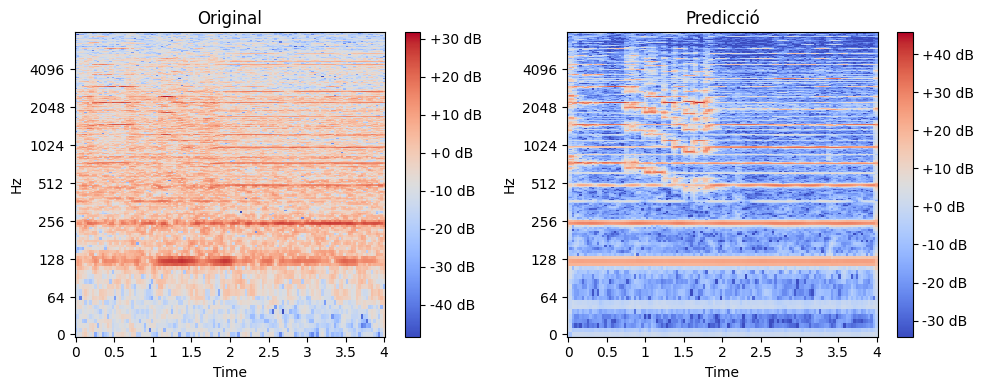

Pitch Accuracy: 72.97%
                                             archivo        LSD
0  /content/drive/MyDrive/2024 25/TFG/NEW_TFG/Dat...  14.448812


In [28]:
pares = [
    ("/content/drive/MyDrive/2024 25/TFG/NEW_TFG/DataSet/DDSP/Resintesi/Model B/resynth_gaita de Barquín - consello da cultura Gallega.wav",
     "/content/drive/MyDrive/2024 25/TFG/NEW_TFG/DataSet/DDSP/Resintesi/original/2gaita de Barquín - consello da cultura Gallega.wav"),

]

resultados = []
for orig, pred in pares:
    lsd = comparar_audios(orig, pred)

    ########################################

    y_true, sr = librosa.load(orig, sr=None)
    y_pred, _ = librosa.load(pred, sr=sr)

    # Extraer pitch con pyin (más preciso que librosa.yin)
    f0_true, voiced_flag_true, _ = librosa.pyin(y_true, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    f0_pred, voiced_flag_pred, _ = librosa.pyin(y_pred, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    min_len = min(len(f0_true), len(f0_pred))
    f0_true = f0_true[:min_len]
    f0_pred = f0_pred[:min_len]
    # Evitar ceros o NaN
    mask = (~np.isnan(f0_true)) & (~np.isnan(f0_pred))

    # Diferencia en cent
    cent_diff = 1200 * np.log2(f0_pred[mask] / f0_true[mask])
    # 50 cent es el margen típico (la mitad de un semitono)
    tolerance_cents = 50
    pitch_accuracy = np.mean(np.abs(cent_diff) < tolerance_cents)
    print(f"Pitch Accuracy: {pitch_accuracy * 100:.2f}%")
    ########################################

    resultados.append({"archivo": orig, "LSD": lsd})

import pandas as pd
df = pd.DataFrame(resultados)
print(df)


LSD entre G4_32.wav y resynth_G4_32.wav: 17.54 dB


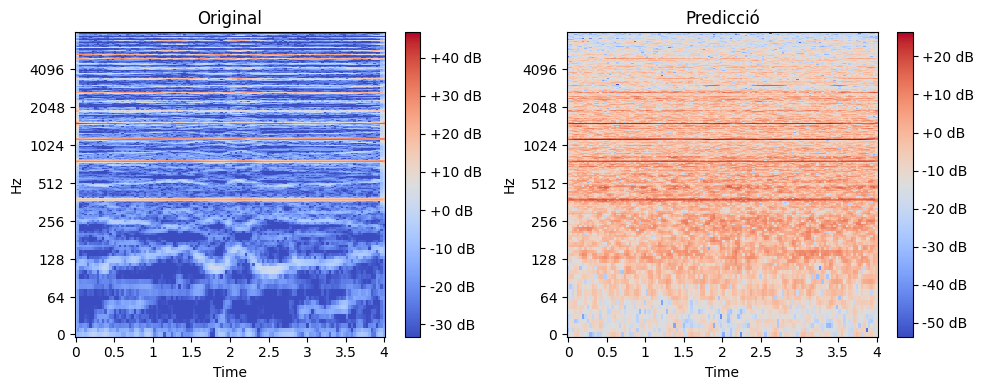

LSD entre Fairy Dance – Unknown.wav y resynth_Fairy Dance – Unknown.wav: 13.86 dB


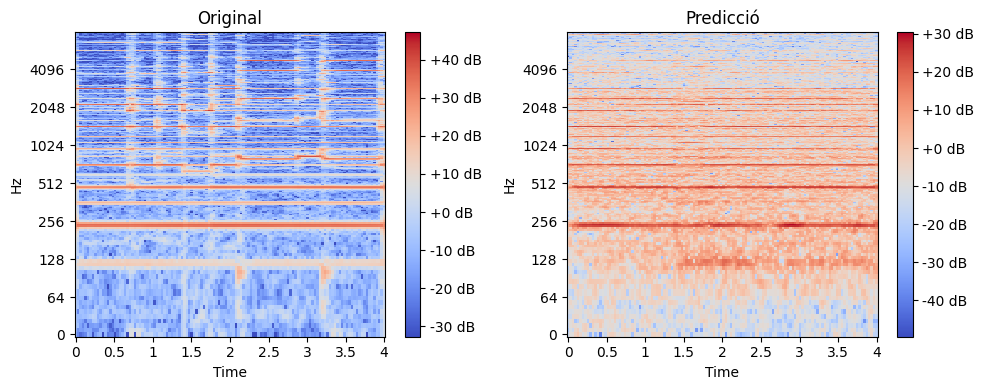

LSD entre gaita de Barquín - consello da cultura Gallega.wav y resynth_gaita de Barquín - consello da cultura Gallega.wav: 14.45 dB


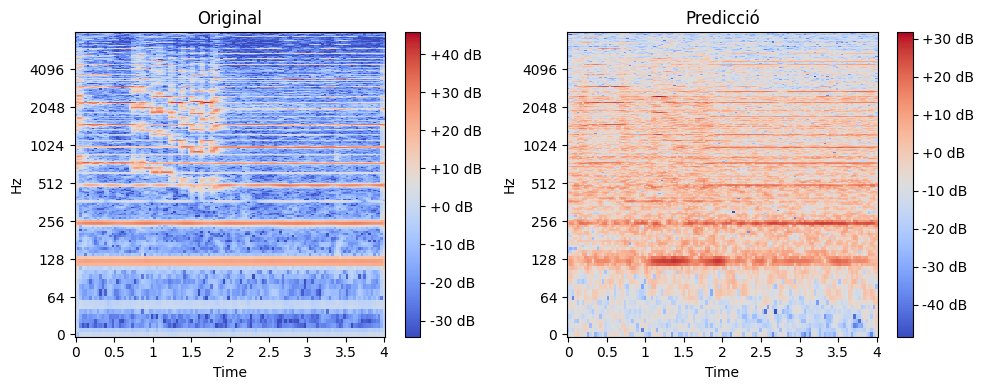

                                             archivo        LSD  \
0                                  resynth_G4_32.wav  17.539976   
1                  resynth_Fairy Dance – Unknown.wav  13.862180   
2  resynth_gaita de Barquín - consello da cultur...  14.448812   

   Pitch Accuracy (%)  
0              100.00  
1               36.97  
2               72.97  


In [30]:
import os
import librosa
import numpy as np
import pandas as pd


# Rutas base
base_resynth = "/content/drive/MyDrive/2024 25/TFG/NEW_TFG/DataSet/DDSP/Resintesi"
resynth_dir = os.path.join(base_resynth, "Model B")  # Cambia esto si quieres otro modelo
original_dir = os.path.join(base_resynth, "original")




# Obtener todos los archivos resintetizados
resynth_files = [f for f in os.listdir(resynth_dir) if f.endswith('.wav')]

resultados = []

for filename in resynth_files:
    resynth_path = os.path.join(resynth_dir, filename)
    orig_filename = filename.replace("resynth_", "")
    original_path = os.path.join(original_dir, orig_filename)

    if not os.path.exists(original_path):
        print(f"Original missing for {filename}, skipping.")
        continue

    # Calcular LSD (aquí deberías usar tu propia función comparar_audios)
    lsd = comparar_audios(original_path, resynth_path)

    # Cargar audio
    y_true, sr = librosa.load(original_path, sr=None)
    y_pred, _ = librosa.load(resynth_path, sr=sr)

    # Pitch
    f0_true, _, _ = librosa.pyin(y_true, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    f0_pred, _, _ = librosa.pyin(y_pred, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    min_len = min(len(f0_true), len(f0_pred))
    f0_true = f0_true[:min_len]
    f0_pred = f0_pred[:min_len]

    mask = (~np.isnan(f0_true)) & (~np.isnan(f0_pred))
    if np.any(mask):
        cent_diff = 1200 * np.log2(f0_pred[mask] / f0_true[mask])
        pitch_accuracy = np.mean(np.abs(cent_diff) < 50)
    else:
        pitch_accuracy = np.nan

    resultados.append({
        "archivo": filename,
        "LSD": lsd,
        "Pitch Accuracy (%)": round(pitch_accuracy * 100, 2) if not np.isnan(pitch_accuracy) else "N/A"
    })

# Mostrar tabla
df = pd.DataFrame(resultados)
print(df)


LSD entre Fairy Dance – Unknown.wav y resynth_Fairy Dance – Unknown.wav: 14.43 dB


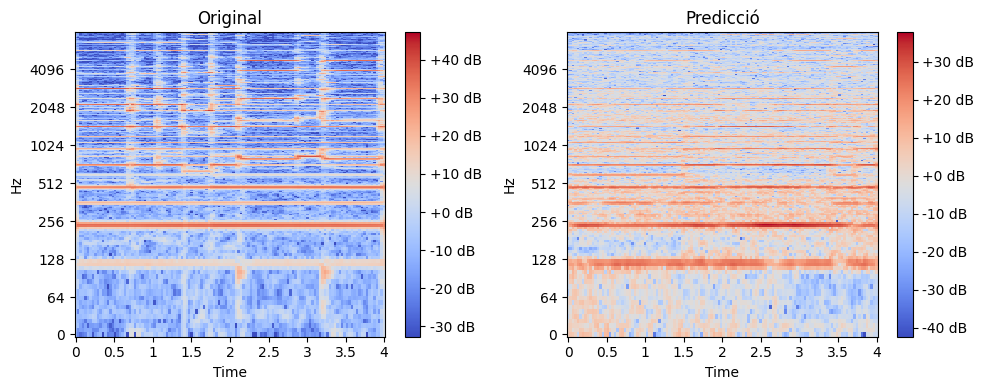

LSD entre G4_32.wav y resynth_G4_32.wav: 21.70 dB


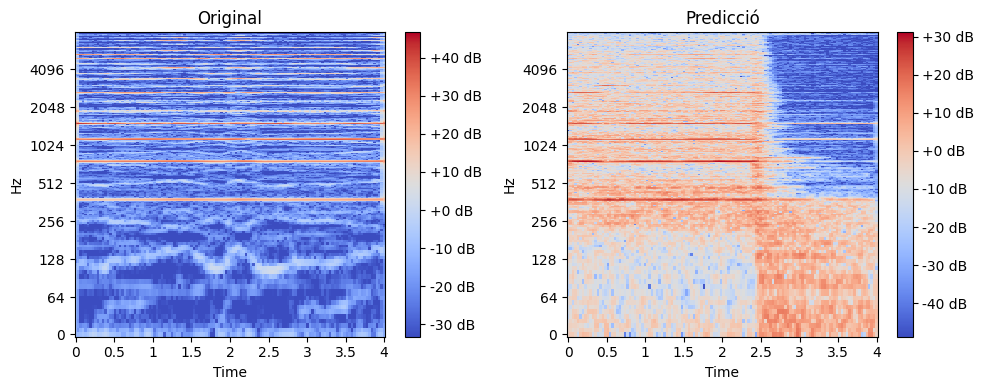

LSD entre gaita de Barquín - consello da cultura Gallega.wav y resynth_gaita de Barquín - consello da cultura Gallega.wav: 15.36 dB


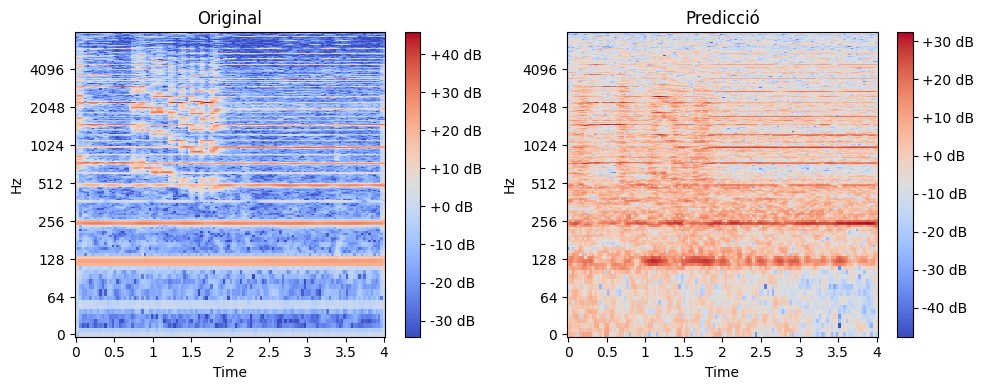

                                             archivo        LSD  \
0                  resynth_Fairy Dance – Unknown.wav  14.430838   
1                                  resynth_G4_32.wav  21.700184   
2  resynth_gaita de Barquín - consello da cultur...  15.362687   

   Pitch Accuracy (%)  
0                7.32  
1              100.00  
2               36.78  


In [34]:
import os
import librosa
import numpy as np
import pandas as pd


# Rutas base
base_resynth = "/content/drive/MyDrive/2024 25/TFG/NEW_TFG/DataSet/DDSP/Resintesi"
resynth_dir = os.path.join(base_resynth, "Model E")  # Cambia esto si quieres otro modelo
original_dir = os.path.join(base_resynth, "original")




# Obtener todos los archivos resintetizados
resynth_files = [f for f in os.listdir(resynth_dir) if f.endswith('.wav')]

resultados = []

for filename in resynth_files:
    resynth_path = os.path.join(resynth_dir, filename)
    orig_filename = filename.replace("resynth_", "")
    original_path = os.path.join(original_dir, orig_filename)

    if not os.path.exists(original_path):
        print(f"Original missing for {filename}, skipping.")
        continue

    # Calcular LSD (aquí deberías usar tu propia función comparar_audios)
    lsd = comparar_audios(original_path, resynth_path)

    # Cargar audio
    y_true, sr = librosa.load(original_path, sr=None)
    y_pred, _ = librosa.load(resynth_path, sr=sr)

    # Pitch
    f0_true, _, _ = librosa.pyin(y_true, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    f0_pred, _, _ = librosa.pyin(y_pred, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    min_len = min(len(f0_true), len(f0_pred))
    f0_true = f0_true[:min_len]
    f0_pred = f0_pred[:min_len]

    mask = (~np.isnan(f0_true)) & (~np.isnan(f0_pred))
    if np.any(mask):
        cent_diff = 1200 * np.log2(f0_pred[mask] / f0_true[mask])
        pitch_accuracy = np.mean(np.abs(cent_diff) < 50)
    else:
        pitch_accuracy = np.nan

    resultados.append({
        "archivo": filename,
        "LSD": lsd,
        "Pitch Accuracy (%)": round(pitch_accuracy * 100, 2) if not np.isnan(pitch_accuracy) else "N/A"
    })

# Mostrar tabla
df = pd.DataFrame(resultados)
print(df)

In [2]:
def si_sdr(reference, estimation):
    reference = reference - np.mean(reference)
    estimation = estimation - np.mean(estimation)

    # Projection of estimation onto reference
    s_target = np.dot(estimation, reference) / np.dot(reference, reference) * reference
    e_noise = estimation - s_target

    # SI-SDR
    ratio = np.sum(s_target**2) / np.sum(e_noise**2)
    si_sdr_value = 10 * np.log10(ratio + 1e-10)
    return si_sdr_value

In [13]:
import numpy as np

def f0_rmse(f0_true, f0_pred):
    # Asegurarnos de que las longitudes coincidan
    min_len = min(len(f0_true), len(f0_pred))
    f0_true = f0_true[:min_len]
    f0_pred = f0_pred[:min_len]

    # Filtrar frames donde ambos tienen pitch válido
    mask = (~np.isnan(f0_true)) & (~np.isnan(f0_pred))

    if np.any(mask):
        error = f0_true[mask] - f0_pred[mask]
        rmse = np.sqrt(np.mean(error**2))
    else:
        rmse = np.nan
    return rmse


In [16]:
import os
import librosa
import numpy as np
import pandas as pd


# Rutas base
base_resynth = "/content/drive/MyDrive/2024 25/TFG/NEW_TFG/DataSet/DDSP/Resintesi"
resynth_dir = os.path.join(base_resynth, "Model C")  # Cambia esto si quieres otro modelo
original_dir = os.path.join(base_resynth, "original")




# Obtener todos los archivos resintetizados
resynth_files = [f for f in os.listdir(resynth_dir) if f.endswith('.wav')]

resultados = []

for filename in resynth_files:
    resynth_path = os.path.join(resynth_dir, filename)
    orig_filename = filename.replace("resynth_", "")
    original_path = os.path.join(original_dir, orig_filename)

    if not os.path.exists(original_path):
        print(f"Original missing for {filename}, skipping.")
        continue

    # Calcular LSD (aquí deberías usar tu propia función comparar_audios)

    # Cargar audio
    y_true, sr = librosa.load(original_path, sr=None)
    y_pred, _ = librosa.load(resynth_path, sr=sr)

    # Pitch
    f0_true, _, _ = librosa.pyin(y_true, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    f0_pred, _, _ = librosa.pyin(y_pred, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    min_len = min(len(f0_true), len(f0_pred))
    f0_true = f0_true[:min_len]
    f0_pred = f0_pred[:min_len]

    mask = (~np.isnan(f0_true)) & (~np.isnan(f0_pred))
    if np.any(mask):
        cent_diff = 1200 * np.log2(f0_pred[mask] / f0_true[mask])
        pitch_accuracy = np.mean(np.abs(cent_diff) < 50)
    else:
        pitch_accuracy = np.nan


    # Igualar longitudes
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]

    # Calcular SI-SDR
    sdr_score = si_sdr(y_true, y_pred)

    resultados.append({
        "archivo": filename,
        "SI-SDR (dB)": round(sdr_score, 2),
        "Pitch Accuracy (%)": round(pitch_accuracy * 100, 2) if not np.isnan(pitch_accuracy) else "N/A",
    })

# Mostrar tabla
df = pd.DataFrame(resultados)
print(df)

                                             archivo  SI-SDR (dB)  \
0                  resynth_Fairy Dance – Unknown.wav       -28.15   
1                                  resynth_G4_32.wav       -36.70   
2  resynth_gaita de Barquín - consello da cultur...       -52.88   

   Pitch Accuracy (%)  F0 RMSE (Hz)  
0                7.32        147.94  
1                0.00        353.46  
2               36.08        134.51  
